# Age and Gender detection 

## Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("age_gender.csv")


In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


## Data PreProcessing

In [5]:
data = df.drop("img_name", axis=1)

In [6]:
data.isnull().sum()

age          0
ethnicity    0
gender       0
pixels       0
dtype: int64

In [11]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [27]:
# Reshape images for CNN
X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255
# Set some useful variables
input_shape = X_reshaped.shape[1:] 

# Set y
y = df['age'].values
y_gender=df['gender'].values

## Visualization

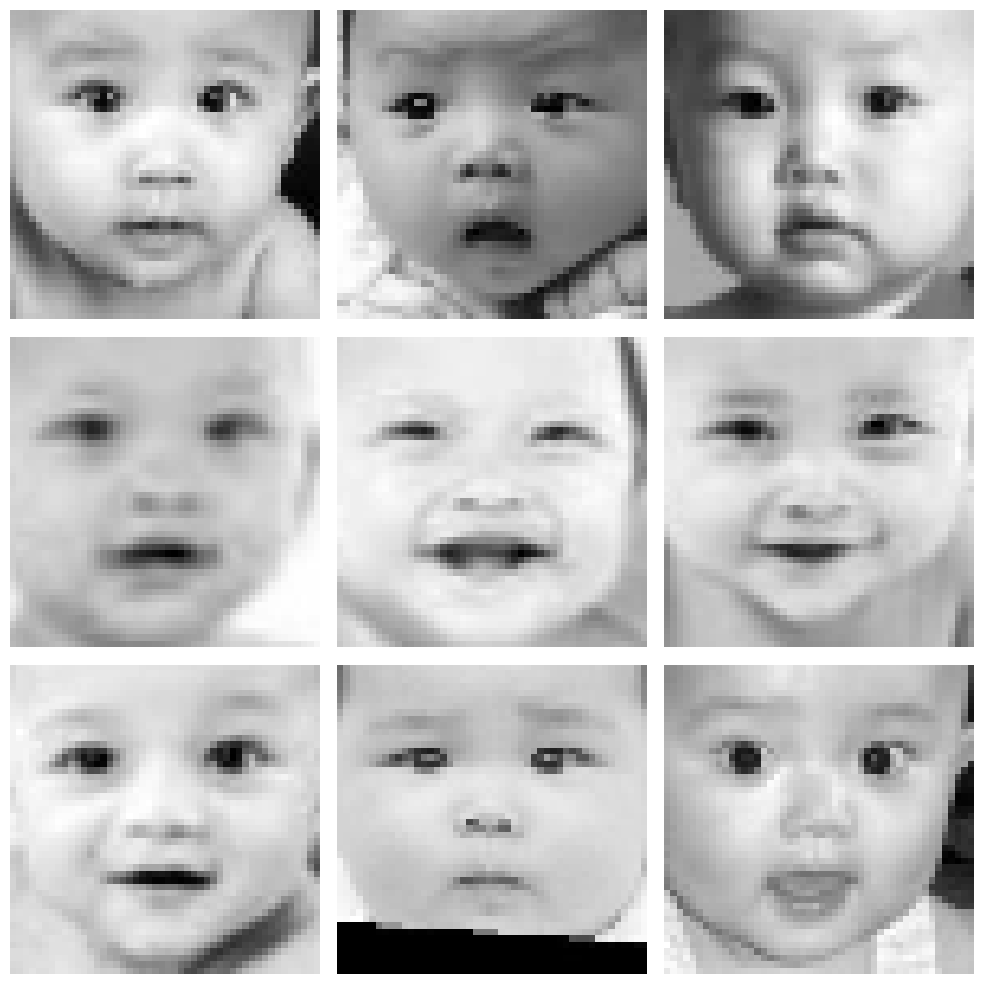

In [7]:
subset_data = data.head(9)

# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Iterate over the subset data and display images
for i, ax in enumerate(axs.flat):
    img_pixels = np.fromstring(subset_data.iloc[i]['pixels'], dtype=int, sep=' ')
    img_pixels = img_pixels.reshape((48, 48))
    ax.imshow(img_pixels, cmap='gray')
    ax.axis('off')

# Display the plot
plt.tight_layout()
plt.show()

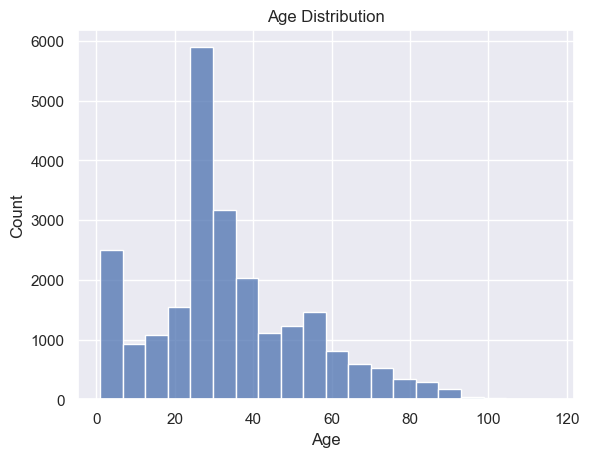

In [8]:
sns.histplot(data['age'], bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()


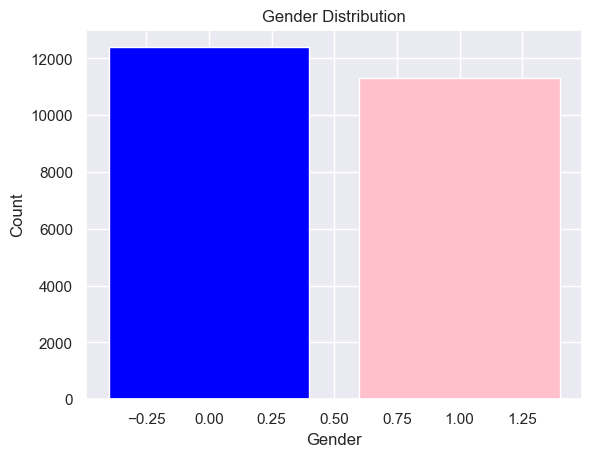

In [9]:
gender_counts = data['gender'].value_counts()

plt.bar(gender_counts.index, gender_counts.values, color=['blue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

plt.show()

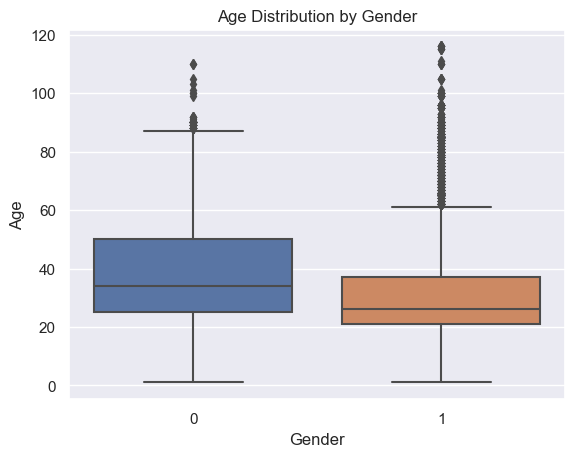

In [10]:
sns.boxplot(x='gender', y='age', data=data)
plt.xlabel('Gender')
plt.ylabel('Age')
plt.title('Age Distribution by Gender')
plt.show()

## Spliting the data

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=123)

In [29]:
X_gtrain, X_gtest, y_gtrain, y_gtest = train_test_split(X_reshaped, y_gender, test_size=0.2, random_state=123)

# 1. Simple model

In [6]:
model_1 = Sequential()

model_1.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1, activation='linear'))

model_1.compile(optimizer='adam', loss='mean_absolute_error')

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [7]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [8]:
history = model_1.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 44s 140ms/step - loss: 15.9855 - val_loss: 14.0953 - lr: 0.0010
Epoch 2/35
297/297 [==============================] - 50s 167ms/step - loss: 13.7909 - val_loss: 12.7824 - lr: 0.0010
Epoch 3/35
297/297 [==============================] - 44s 148ms/step - loss: 11.8603 - val_loss: 10.9929 - lr: 0.0010
Epoch 4/35
297/297 [==============================] - 42s 140ms/step - loss: 10.9352 - val_loss: 9.9302 - lr: 0.0010
Epoch 5/35
297/297 [==============================] - 39s 132ms/step - loss: 10.2652 - val_loss: 9.1737 - lr: 0.0010
Epoch 6/35
297/297 [==============================] - 48s 161ms/step - loss: 9.8984 - val_loss: 12.8350 - lr: 0.0010
Epoch 7/35
297/297 [==============================] - 47s 160ms/step - loss: 9.5723 - val_loss: 8.6086 - lr: 0.0010
Epoch 8/35
297/297 [==============================] - 46s 155ms/step - loss: 9.0019 - val_loss: 8.3524 - lr: 0.0010
Epoch 9/35
297/297 [==============================] - 47s 158ms

<Axes: >

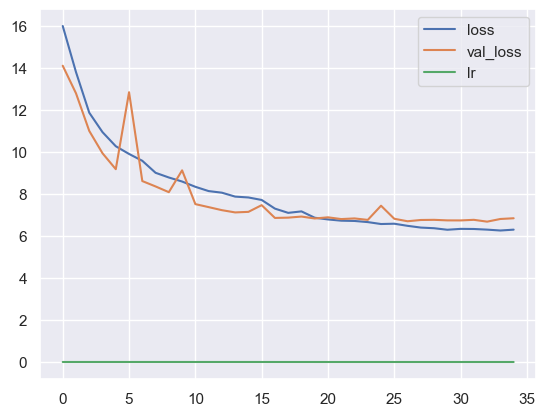

In [9]:
pd.DataFrame(history.history).plot()

In [13]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_1.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 3s 19ms/step
R2 score: 0.621


In [11]:
history=model_1.fit(X_gtrain,y_gtrain,epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_gtest, y_gtest))

Epoch 1/35
297/297 [==============================] - 56s 187ms/step - loss: 1.9177 - val_loss: 0.4286 - lr: 1.0000e-04
Epoch 2/35
297/297 [==============================] - 49s 163ms/step - loss: 0.5124 - val_loss: 0.3814 - lr: 1.0000e-04
Epoch 3/35
297/297 [==============================] - 52s 177ms/step - loss: 0.4847 - val_loss: 0.3701 - lr: 1.0000e-04
Epoch 4/35
297/297 [==============================] - 48s 161ms/step - loss: 0.4668 - val_loss: 0.3594 - lr: 1.0000e-04
Epoch 5/35
297/297 [==============================] - 46s 155ms/step - loss: 0.4599 - val_loss: 0.3695 - lr: 1.0000e-04
Epoch 6/35
297/297 [==============================] - 52s 176ms/step - loss: 0.4515 - val_loss: 0.3393 - lr: 1.0000e-04
Epoch 7/35
297/297 [==============================] - 60s 202ms/step - loss: 0.4402 - val_loss: 0.3458 - lr: 1.0000e-04
Epoch 8/35
297/297 [==============================] - 50s 167ms/step - loss: 0.4274 - val_loss: 0.3345 - lr: 1.0000e-04
Epoch 9/35
297/297 [====================

<Axes: >

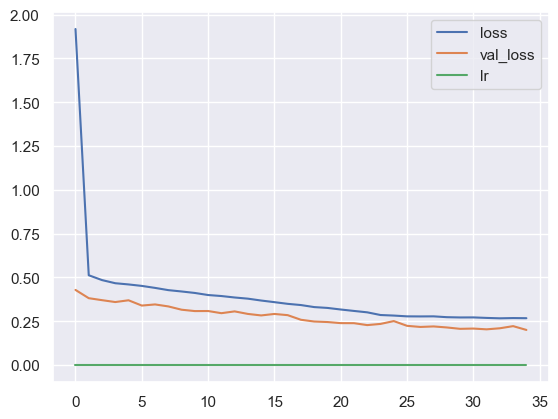

In [12]:
pd.DataFrame(history.history).plot()

In [53]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_4.predict(X_gtest)

# calculate R2 score
r2 = r2_score(y_gtest, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.471


# 2. Complex model

In [30]:
model_2 = Sequential()

model_2.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu', padding='same'))
model_2.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(BatchNormalization())

model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.3))
model_2.add(BatchNormalization())

model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.4))
model_2.add(BatchNormalization())

model_2.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.5))
model_2.add(BatchNormalization())

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(1))

model_2.compile(optimizer='adam', loss='mean_absolute_error')

model_2.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)      

In [31]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [32]:
history = model_2.fit(X_train, y_train, 
                        epochs=35,   
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 154s 461ms/step - loss: 12.7507 - val_loss: 35.5548
Epoch 2/35
297/297 [==============================] - 132s 444ms/step - loss: 9.5810 - val_loss: 32.9030
Epoch 3/35
297/297 [==============================] - 132s 445ms/step - loss: 8.4795 - val_loss: 9.6012
Epoch 4/35
297/297 [==============================] - 100s 336ms/step - loss: 8.1753 - val_loss: 8.4385
Epoch 5/35
297/297 [==============================] - 130s 438ms/step - loss: 7.7893 - val_loss: 7.8098
Epoch 6/35
297/297 [==============================] - 132s 444ms/step - loss: 7.5424 - val_loss: 16.6573
Epoch 7/35
297/297 [==============================] - 130s 439ms/step - loss: 7.2386 - val_loss: 7.0346
Epoch 8/35
297/297 [==============================] - 131s 440ms/step - loss: 7.0283 - val_loss: 10.3301
Epoch 9/35
297/297 [==============================] - 130s 439ms/step - loss: 7.0161 - val_loss: 12.0500

Epoch 00009: ReduceLROnPlateau reducing learning rate to 

<AxesSubplot:>

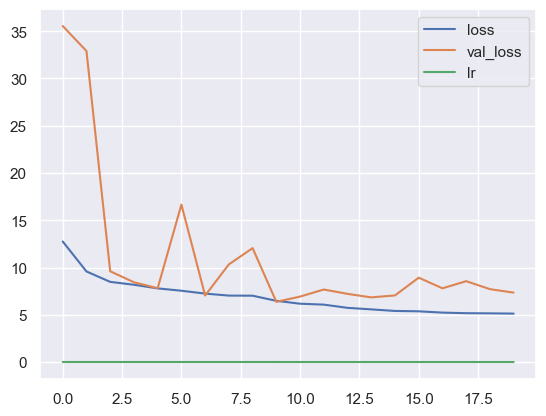

In [33]:
pd.DataFrame(history.history).plot()

In [10]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_1.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

149/149 [==============================] - 5s 30ms/step
R2 score: 0.770


In [35]:
history=model_2.fit(X_gtrain,y_gtrain,epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_gtest, y_gtest))

Epoch 1/35
297/297 [==============================] - 39s 133ms/step - loss: 2.8818 - val_loss: 0.4427
Epoch 2/35
297/297 [==============================] - 39s 132ms/step - loss: 0.4502 - val_loss: 0.3836
Epoch 3/35
297/297 [==============================] - 39s 132ms/step - loss: 0.4077 - val_loss: 0.3461
Epoch 4/35
297/297 [==============================] - 122s 412ms/step - loss: 0.3767 - val_loss: 0.3163
Epoch 5/35
297/297 [==============================] - 131s 440ms/step - loss: 0.3489 - val_loss: 0.3001
Epoch 6/35
297/297 [==============================] - 131s 440ms/step - loss: 0.3312 - val_loss: 0.2724
Epoch 7/35
297/297 [==============================] - 131s 440ms/step - loss: 0.3145 - val_loss: 0.2631
Epoch 8/35
297/297 [==============================] - 131s 440ms/step - loss: 0.2962 - val_loss: 0.2440
Epoch 9/35
297/297 [==============================] - 131s 441ms/step - loss: 0.2803 - val_loss: 0.2211
Epoch 10/35
297/297 [==============================] - 114s 382ms/s

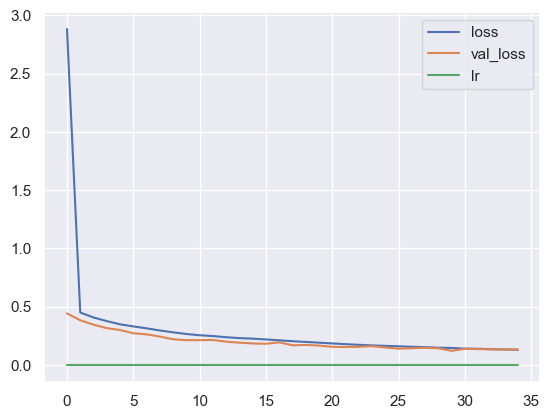

In [36]:
pd.DataFrame(history.history).plot();

In [37]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_2.predict(X_gtest)

# calculate R2 score
r2 = r2_score(y_gtest, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.653


# 3. Model with adjusted Flatten layer

In [38]:
model_3 = Sequential()

model_3.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(BatchNormalization())

model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.3))
model_3.add(BatchNormalization())

model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.3))
model_3.add(BatchNormalization())

model_3.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model_3.add(MaxPooling2D(pool_size=(2,2)))
model_3.add(Dropout(0.5))
model_3.add(BatchNormalization())

model_3.add(Flatten())
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(1))

model_3.compile(optimizer='adam', loss='mean_absolute_error')

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 10, 128)      

In [39]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [40]:
history = model_3.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 74s 225ms/step - loss: 11.1213 - val_loss: 22.7665
Epoch 2/35
297/297 [==============================] - 65s 220ms/step - loss: 8.6618 - val_loss: 32.1438
Epoch 3/35
297/297 [==============================] - 62s 210ms/step - loss: 8.0641 - val_loss: 22.1748
Epoch 4/35
297/297 [==============================] - 66s 222ms/step - loss: 7.7071 - val_loss: 20.2148
Epoch 5/35
297/297 [==============================] - 64s 217ms/step - loss: 7.5577 - val_loss: 6.8247
Epoch 6/35
297/297 [==============================] - 62s 209ms/step - loss: 7.2714 - val_loss: 7.5556
Epoch 7/35
297/297 [==============================] - 49s 163ms/step - loss: 7.0843 - val_loss: 7.2295

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/35
297/297 [==============================] - 62s 210ms/step - loss: 6.5865 - val_loss: 6.2579
Epoch 9/35
297/297 [==============================] - 62s 210ms/step - loss: 6.3371 - val_

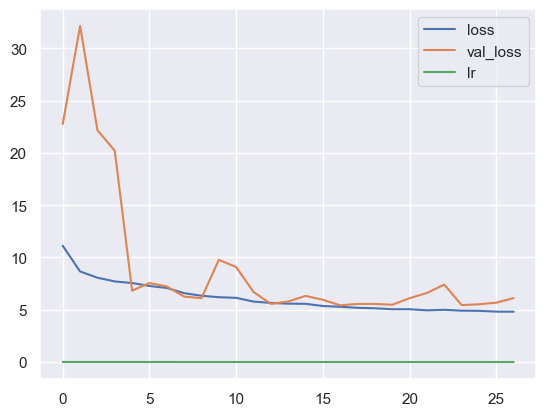

In [41]:
pd.DataFrame(history.history).plot();

In [42]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_3.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.848


In [43]:
history=model_3.fit(X_gtrain,y_gtrain,epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_gtest, y_gtest))

Epoch 1/35
297/297 [==============================] - 62s 209ms/step - loss: 3.7989 - val_loss: 0.4472
Epoch 2/35
297/297 [==============================] - 62s 209ms/step - loss: 0.4699 - val_loss: 0.3697
Epoch 3/35
297/297 [==============================] - 62s 209ms/step - loss: 0.4093 - val_loss: 0.3225
Epoch 4/35
297/297 [==============================] - 62s 209ms/step - loss: 0.3776 - val_loss: 0.3001
Epoch 5/35
297/297 [==============================] - 62s 209ms/step - loss: 0.3577 - val_loss: 0.2803
Epoch 6/35
297/297 [==============================] - 62s 209ms/step - loss: 0.3431 - val_loss: 0.2652
Epoch 7/35
297/297 [==============================] - 62s 209ms/step - loss: 0.3319 - val_loss: 0.2589
Epoch 8/35
297/297 [==============================] - 62s 209ms/step - loss: 0.3242 - val_loss: 0.2440
Epoch 9/35
297/297 [==============================] - 63s 212ms/step - loss: 0.3109 - val_loss: 0.2360
Epoch 10/35
297/297 [==============================] - 63s 211ms/step - l

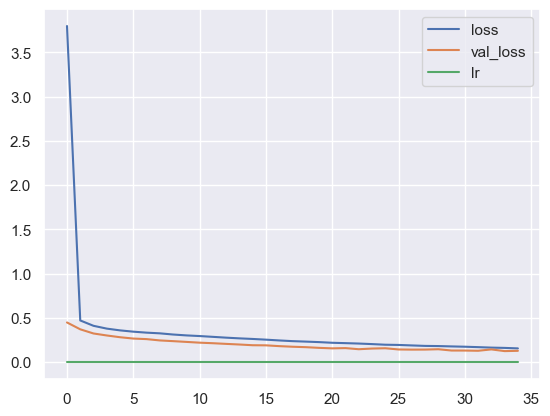

In [44]:
pd.DataFrame(history.history).plot();

In [45]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_3.predict(X_gtest)

# calculate R2 score
r2 = r2_score(y_gtest, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.685


# 4.Model balanced

In [46]:
model_4 = Sequential()

model_4.add(Conv2D(128, kernel_size=(2,2), input_shape=input_shape, activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(BatchNormalization())

model_4.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))
model_4.add(BatchNormalization())

model_4.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.3))
model_4.add(BatchNormalization())

model_4.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
model_4.add(MaxPooling2D(pool_size=(2,2)))
model_4.add(Dropout(0.5))
model_4.add(BatchNormalization())

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(32, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1))

model_4.compile(optimizer='adam', loss='mean_absolute_error')

model_4.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 47, 47, 128)       640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 23, 23, 128)       512       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 23, 128)       147584    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 21, 21, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 10, 10, 128)      

In [47]:
# Callbacks for age model
callbacks = [EarlyStopping(patience=10, 
                               min_delta=0.001,
                               restore_best_weights=True),
             ReduceLROnPlateau(patience = 2,
                               verbose=1,
                               factor=0.5,
                               min_lr = 0.0001)]

In [48]:
history = model_4.fit(X_train, y_train, 
                        epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_test, y_test))

Epoch 1/35
297/297 [==============================] - 83s 269ms/step - loss: 12.7629 - val_loss: 35.7815
Epoch 2/35
297/297 [==============================] - 78s 264ms/step - loss: 9.9310 - val_loss: 27.5806
Epoch 3/35
297/297 [==============================] - 78s 264ms/step - loss: 9.3522 - val_loss: 7.8345
Epoch 4/35
297/297 [==============================] - 78s 264ms/step - loss: 8.7748 - val_loss: 7.8658
Epoch 5/35
297/297 [==============================] - 78s 264ms/step - loss: 8.4627 - val_loss: 7.2979
Epoch 6/35
297/297 [==============================] - 78s 264ms/step - loss: 8.2679 - val_loss: 7.1660
Epoch 7/35
297/297 [==============================] - 79s 265ms/step - loss: 8.2259 - val_loss: 7.1805
Epoch 8/35
297/297 [==============================] - 78s 264ms/step - loss: 7.9197 - val_loss: 7.3726

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 9/35
297/297 [==============================] - 78s 264ms/step - loss: 7.5658 - val_lo

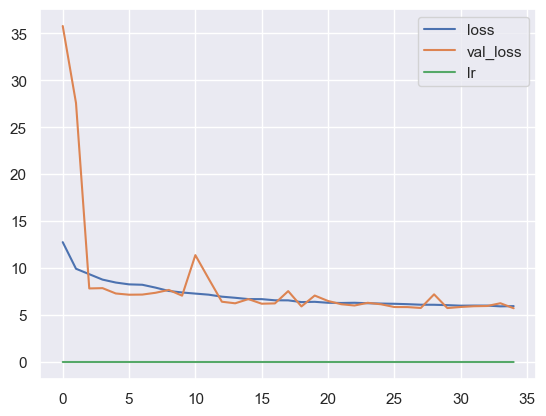

In [49]:
pd.DataFrame(history.history).plot();

In [50]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_4.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.833


In [51]:
history=model_4.fit(X_gtrain,y_gtrain,epochs=35,
                        batch_size=64,
                        callbacks=callbacks,
                        validation_data=(X_gtest, y_gtest))

Epoch 1/35
297/297 [==============================] - 79s 266ms/step - loss: 3.9597 - val_loss: 0.5624
Epoch 2/35
297/297 [==============================] - 79s 266ms/step - loss: 0.6237 - val_loss: 0.4914
Epoch 3/35
297/297 [==============================] - 79s 266ms/step - loss: 0.5778 - val_loss: 0.4557
Epoch 4/35
297/297 [==============================] - 79s 266ms/step - loss: 0.5421 - val_loss: 0.4301
Epoch 5/35
297/297 [==============================] - 79s 266ms/step - loss: 0.5098 - val_loss: 0.4054
Epoch 6/35
297/297 [==============================] - 79s 266ms/step - loss: 0.4883 - val_loss: 0.3857
Epoch 7/35
297/297 [==============================] - 79s 266ms/step - loss: 0.4644 - val_loss: 0.3803
Epoch 8/35
297/297 [==============================] - 79s 266ms/step - loss: 0.4425 - val_loss: 0.3698
Epoch 9/35
297/297 [==============================] - 79s 267ms/step - loss: 0.4261 - val_loss: 0.3644
Epoch 10/35
297/297 [==============================] - 79s 266ms/step - l

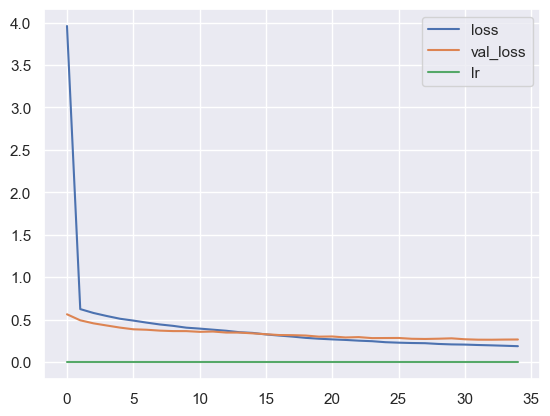

In [52]:
pd.DataFrame(history.history).plot();

In [ ]:
from sklearn.metrics import r2_score

# Make predictions 
y_pred = model_2.predict(X_test)

# calculate R2 score
r2 = r2_score(y_test, y_pred)

print("R2 score: {:.3f}".format(r2))

R2 score: 0.798
